In [2]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
from dataclasses import dataclass
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind
import requests
import pandas as pd
import json

In [3]:

def get_uniswap_data(pool_id, number_of_days,url):
    url = url
    query = f"""
    {{
        poolDayDatas(where: {{ pool: "{pool_id}" }}, first: {number_of_days}, orderBy: date, orderDirection: desc) {{
            date
            tick
            sqrtPrice
            liquidity
            volumeUSD
            volumeToken0
            volumeToken1
            tvlUSD
            feesUSD
        }}
    }}
    """
    response = requests.post(url, json={'query': query})
    data = response.json()

    return data['data']['poolDayDatas']

In [6]:
number_of_days=1000

treatment_pool_id= #wstethop"0x4a5a2a152e985078e1a4aa9c3362c412b7dd0a86"
treatment_url="https://api.thegraph.com/subgraphs/name/ianlapham/optimism-post-regenesis"

control_pool_id= #stetheth"0xd340b57aacdd10f96fc1cf10e15921936f41e29c"
control_url="https://api.thegraph.com/subgraphs/name/ianlapham/optimism-post-regenesis"#"https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3"

# Define Incentive and sample periods

incentive_start_date = pd.to_datetime('2023-01-18')
incentive_end_date = pd.to_datetime('2023-02-08')

incentive_period = incentive_end_date - incentive_start_date

sample_start = incentive_start_date - incentive_period
sample_end = incentive_end_date + incentive_period


uniswap_data = get_uniswap_data(treatment_pool_id,number_of_days,treatment_url)
treatment_df = pd.DataFrame(uniswap_data)

uniswap_data = get_uniswap_data(control_pool_id,number_of_days,control_url)
control_df = pd.DataFrame(uniswap_data)

#Datatypes formatting
treatment_df['volumeUSD'] = treatment_df['volumeUSD'].astype(float)
treatment_df['volumeToken0'] = treatment_df['volumeToken0'].astype(float)
treatment_df['volumeToken1'] = treatment_df['volumeToken1'].astype(float)
treatment_df['sqrtPrice'] = (treatment_df['sqrtPrice'].astype(float))/(2**96)
treatment_df['liquidity'] = treatment_df['liquidity'].astype(float)
treatment_df['tvlUSD'] = treatment_df['tvlUSD'].astype(float)
treatment_df['fees'] = treatment_df['feesUSD'].astype(float)
treatment_df['date'] = pd.to_datetime(treatment_df['date'], unit='s')


#Data formatting
control_df['volumeUSD'] = control_df['volumeUSD'].astype(float)
control_df['volumeToken0'] = control_df['volumeToken0'].astype(float)
control_df['volumeToken1'] = control_df['volumeToken1'].astype(float)
control_df['sqrtPrice'] = (control_df['sqrtPrice'].astype(float))/2**96
control_df['liquidity'] = control_df['liquidity'].astype(float)
control_df['tvlUSD'] = control_df['tvlUSD'].astype(float)
control_df['fees'] = control_df['feesUSD'].astype(float)
control_df['date'] = pd.to_datetime(control_df['date'], unit='s')
#treatment_df['fees']= treatment_df['fees'].rolling(window=7).mean()
#control_df['fees']= control_df['fees'].rolling(window=7).mean()


In [7]:
#Marketshare
# Calculate market share for TVL
total_tvl = treatment_df['tvlUSD'] + control_df['tvlUSD']
treatment_df['market_share_tvl'] = (treatment_df['tvlUSD'] / total_tvl) * 100
control_df['market_share_tvl'] = (control_df['tvlUSD'] / total_tvl) * 100

# Calculate market share for fees
total_fees = treatment_df['fees'] + control_df['fees']
treatment_df['market_share_fees'] = treatment_df['fees'] / total_fees * 100
control_df['market_share_fees'] = control_df['fees'] / total_fees * 100

<Axes: xlabel='date'>

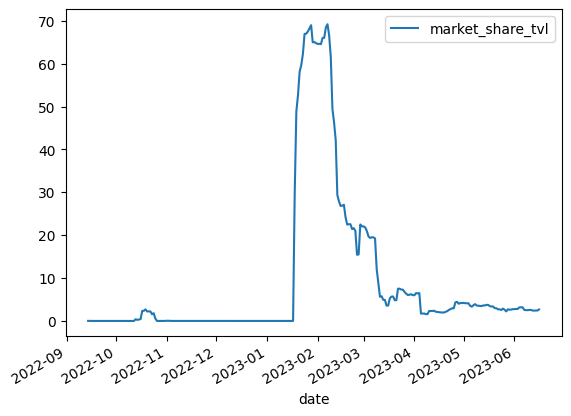

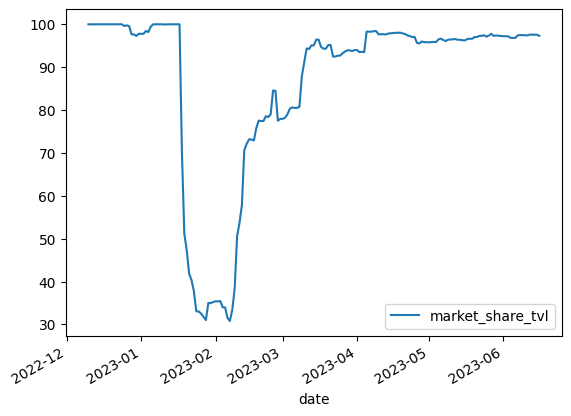

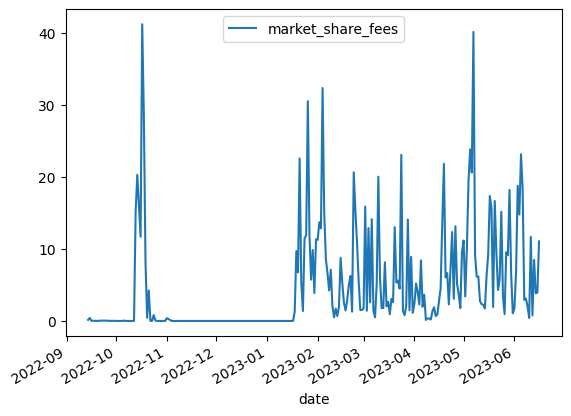

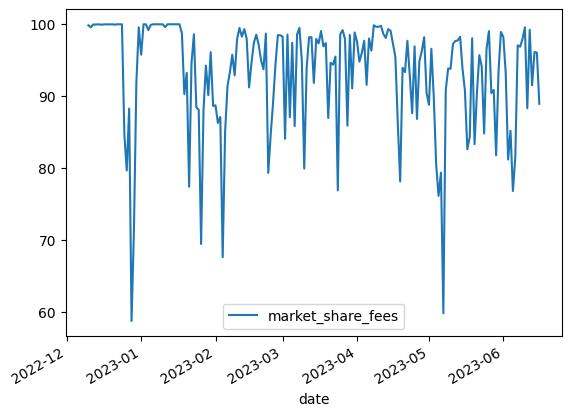

In [10]:
treatment_df.plot('date','market_share_tvl')
control_df.plot('date','market_share_tvl')
treatment_df.plot('date','market_share_fees')
control_df.plot('date','market_share_fees')

In [11]:
# Split the data into before, during, and after the incentive periods for traetment
treatment_before = treatment_df[(treatment_df['date'] >= sample_start) & (treatment_df['date'] < incentive_start_date)].reset_index(drop=True)
treatment_during = treatment_df[(treatment_df['date'] >= incentive_start_date) & (treatment_df['date'] < incentive_end_date)].reset_index(drop=True)
treatment_after = treatment_df[(treatment_df['date'] >= incentive_end_date) & (treatment_df['date'] < sample_end)].reset_index(drop=True)

control_before = control_df[(control_df['date'] >= sample_start) & (control_df['date'] < incentive_start_date)].reset_index(drop=True)
control_during = control_df[(control_df['date'] >= incentive_start_date) & (control_df['date'] < incentive_end_date)].reset_index(drop=True)
control_after = control_df[(control_df['date'] >= incentive_end_date) & (control_df['date'] < sample_end)].reset_index(drop=True)

# Filter the data within the specified time range
treatment_filtered_data = treatment_df.loc[(treatment_df['date'] >= sample_start) & (treatment_df['date'] <= sample_end)]

#for control pool Filter the data within the specified time range
control_filtered_data = control_df.loc[(control_df['date'] >= sample_start) & (control_df['date'] <= sample_end)]

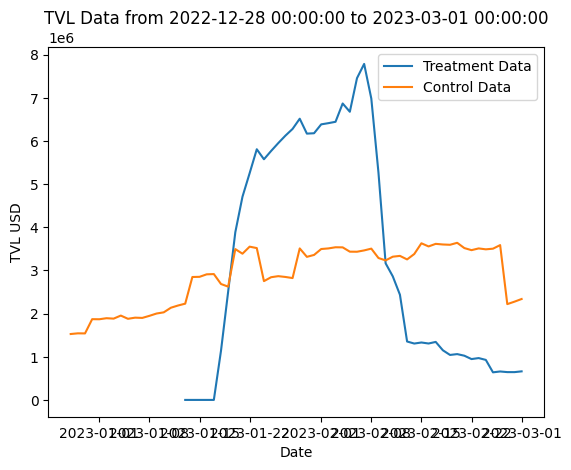

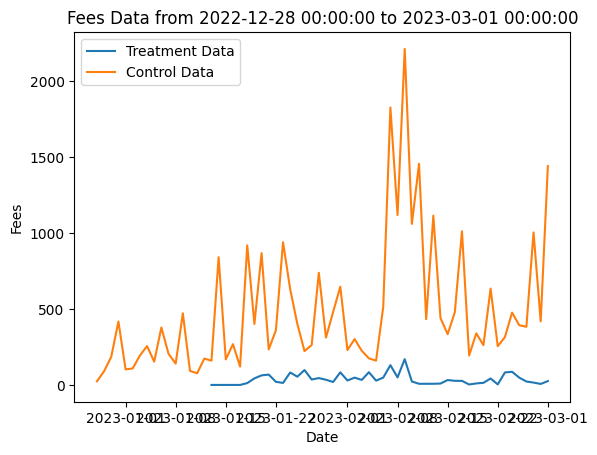

In [12]:
# Plot the filtered data and control data on the same plot
plt.plot(treatment_filtered_data['date'], treatment_filtered_data['tvlUSD'], label='Treatment Data')
plt.plot(control_filtered_data['date'], control_filtered_data['tvlUSD'], label='Control Data')

# Add plot title and axis labels
plt.title(f"TVL Data from {sample_start} to {sample_end}")
plt.xlabel("Date")
plt.ylabel("TVL USD")

# Display the plot with legend
plt.legend()
plt.show()

# Plot the filtered data and control data on the same plot
plt.plot(treatment_filtered_data['date'], treatment_filtered_data['fees'], label='Treatment Data')
plt.plot(control_filtered_data['date'], control_filtered_data['fees'], label='Control Data')

# Add plot title and axis labels
plt.title(f"Fees Data from {sample_start} to {sample_end}")
plt.xlabel("Date")
plt.ylabel("Fees")

# Display the plot with legend
plt.legend()
plt.show()


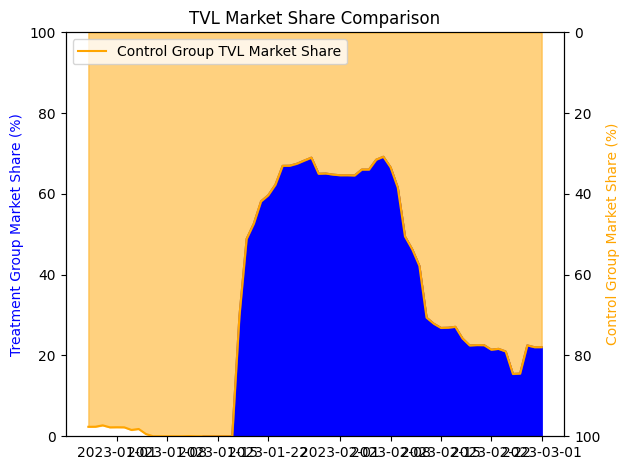

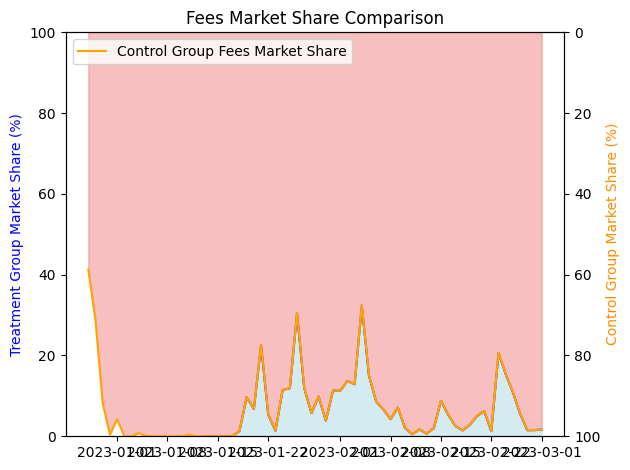

In [14]:
#TVL marketshare
# Create a figure and two subplots
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Plot the treatment group on the lower y-axis
ax1.plot(treatment_filtered_data['date'], treatment_filtered_data['market_share_tvl'], label='Treatment Group TVL Market Share', color='blue')
ax1.fill_between(treatment_filtered_data['date'], treatment_filtered_data['market_share_tvl'], color='blue', alpha=1)
ax1.set_ylabel("Treatment Group Market Share (%)")
ax1.yaxis.label.set_color('blue')

# Plot the control group on the separate y-axis with inverted values
ax2.plot(control_filtered_data['date'], control_filtered_data['market_share_tvl'], label='Control Group TVL Market Share', color='orange')
ax2.fill_between(control_filtered_data['date'], control_filtered_data['market_share_tvl'], color='orange', alpha=0.5)
ax2.set_ylabel("Control Group Market Share (%)")
ax2.yaxis.label.set_color('orange')
ax2.invert_yaxis()  # Invert the y-axis values for the control group
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

# Set the y-axis limits and format for both subplots
ax1.set_ylim([0, 100])
ax2.set_ylim([100, 0])

# Add plot title and common x-axis label
plt.title("TVL Market Share Comparison")
plt.xlabel("Date")

# Display the plot with legend
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#Fee Market share
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Plot the treatment group on the lower y-axis
ax1.plot(treatment_filtered_data['date'], treatment_filtered_data['market_share_fees'], label='Treatment Group Fees Market Share', color='blue')
ax1.fill_between(treatment_filtered_data['date'], treatment_filtered_data['market_share_fees'], color='lightblue', alpha=0.5)
ax1.set_ylabel("Treatment Group Market Share (%)")
ax1.yaxis.label.set_color('blue')

# Plot the control group on the separate y-axis with inverted values
ax2.plot(control_filtered_data['date'], control_filtered_data['market_share_fees'], label='Control Group Fees Market Share', color='orange')
ax2.fill_between(control_filtered_data['date'], control_filtered_data['market_share_fees'], color='lightcoral', alpha=0.5)
ax2.set_ylabel("Control Group Market Share (%)")
ax2.yaxis.label.set_color('darkorange')
ax2.invert_yaxis()  # Invert the y-axis values for the control group
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

# Set the y-axis limits and format for both subplots
ax1.set_ylim([0, 100])
ax2.set_ylim([100, 0])

# Add plot title and common x-axis label
plt.title("Fees Market Share Comparison")
plt.xlabel("Date")

# Display the plot with legend
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

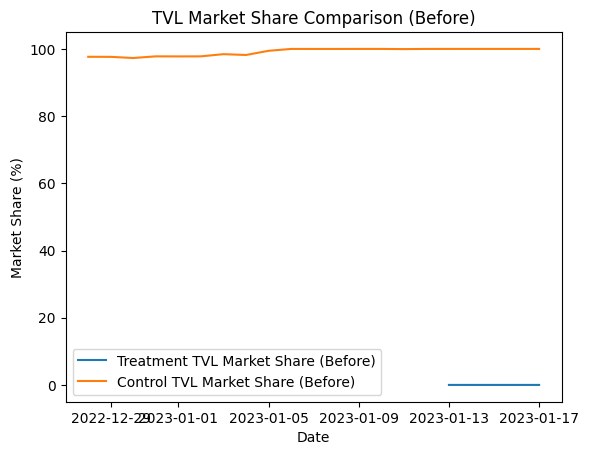

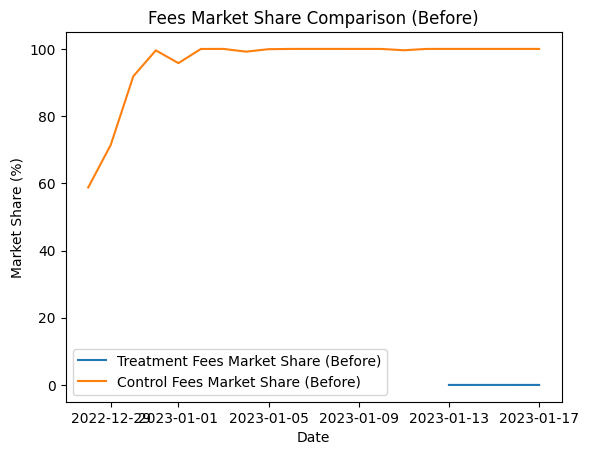

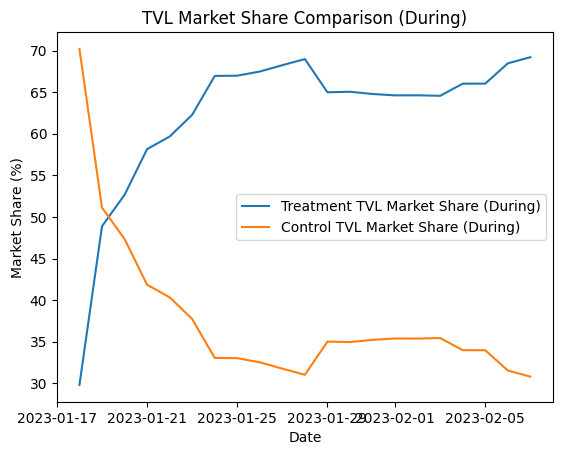

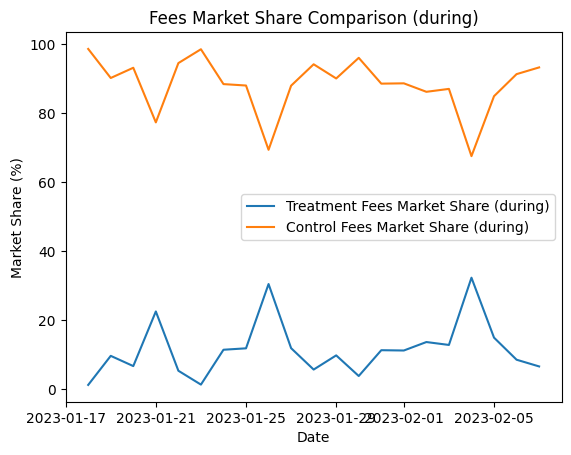

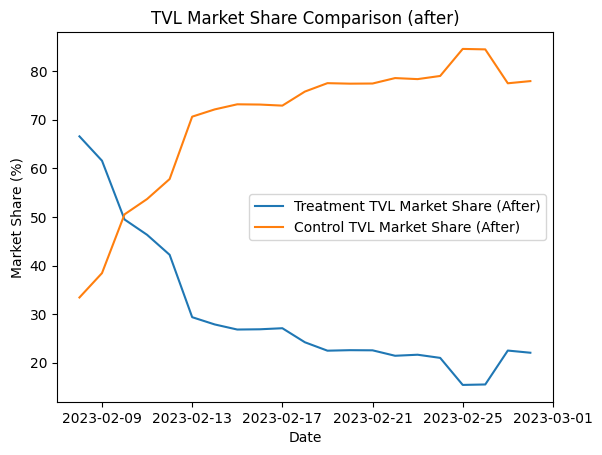

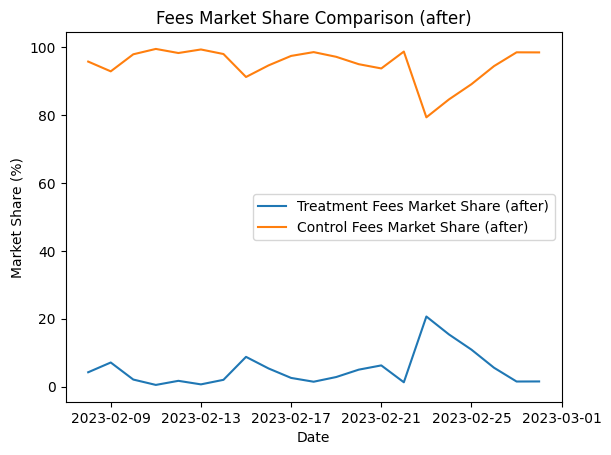

In [15]:
# Plot the TVL market share in the "before" interval for treatment and control groups
plt.plot(treatment_before['date'], treatment_before['market_share_tvl'] , label='Treatment TVL Market Share (Before)')
plt.plot(control_before['date'], control_before['market_share_tvl'] , label='Control TVL Market Share (Before)')
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.title('TVL Market Share Comparison (Before)')
plt.legend()
plt.show()

# Plot the fees market share in the "before" interval for treatment and control groups
plt.plot(treatment_before['date'],treatment_before['market_share_fees'], label='Treatment Fees Market Share (Before)')
plt.plot(control_before['date'], control_before['market_share_fees'], label='Control Fees Market Share (Before)')
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.title('Fees Market Share Comparison (Before)')
plt.legend()
plt.show()

plt.plot(treatment_during['date'], treatment_during['market_share_tvl'], label='Treatment TVL Market Share (During)')
plt.plot(control_during['date'], control_during['market_share_tvl'], label='Control TVL Market Share (During)')
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.title('TVL Market Share Comparison (During)')
plt.legend()
plt.show()

# Plot the fees market share in the "before" interval for treatment and control groups
plt.plot(treatment_during['date'], treatment_during['market_share_fees'], label='Treatment Fees Market Share (during)')
plt.plot(control_during['date'], control_during['market_share_fees'], label='Control Fees Market Share (during)')
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.title('Fees Market Share Comparison (during)')
plt.legend()
plt.show()

plt.plot(treatment_after['date'], treatment_after['market_share_tvl'], label='Treatment TVL Market Share (After)')
plt.plot(control_after['date'], control_after['market_share_tvl'], label='Control TVL Market Share (After)')
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.title('TVL Market Share Comparison (after)')
plt.legend()
plt.show()

# Plot the fees market share in the "before" interval for treatment and control groups
plt.plot(treatment_after['date'], treatment_after['market_share_fees'], label='Treatment Fees Market Share (after)')
plt.plot(control_after['date'], control_after['market_share_fees'], label='Control Fees Market Share (after)')
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.title('Fees Market Share Comparison (after)')
plt.legend()
plt.show()

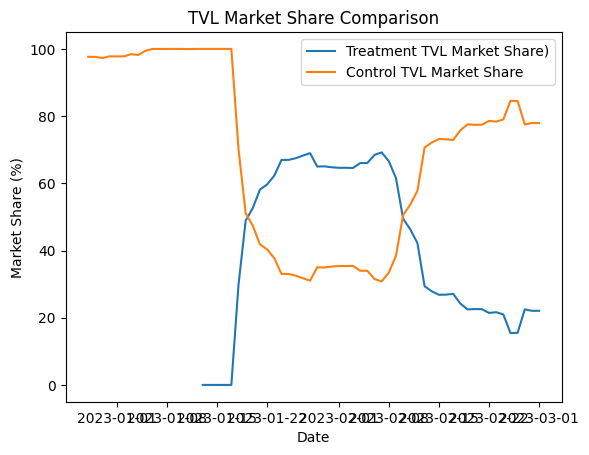

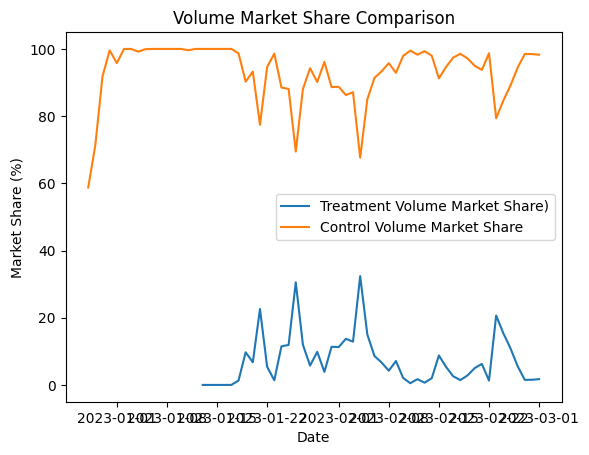

In [19]:
# Plot the TVL market share in the "before" interval for treatment and control groups
plt.plot(treatment_filtered_data['date'], treatment_filtered_data['market_share_tvl'], label='Treatment TVL Market Share)')
plt.plot(control_filtered_data['date'], control_filtered_data['market_share_tvl'], label='Control TVL Market Share')
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.title('TVL Market Share Comparison')
plt.legend()
plt.show()

# Plot the TVL market share in the "before" interval for treatment and control groups
plt.plot(treatment_filtered_data['date'], treatment_filtered_data['market_share_fees'], label='Treatment Volume Market Share)')
plt.plot(control_filtered_data['date'], control_filtered_data['market_share_fees'], label='Control Volume Market Share')
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.title('Volume Market Share Comparison')
plt.legend()
plt.show()

In [16]:
control_during['tvlLift']=control_during['market_share_tvl']-control_before['market_share_tvl']
control_after['tvlLift']=control_after['market_share_tvl']-control_before['market_share_tvl']

treatment_during['tvlLift']=treatment_during['market_share_tvl']-treatment_before['market_share_tvl']
treatment_after['tvlLift']=treatment_after['market_share_tvl']-treatment_before['market_share_tvl']

lift_tvl_during=treatment_during['tvlLift'].mean()-control_during['tvlLift'].mean()
lift_tvl_after=treatment_after['tvlLift'].mean()-control_after['tvlLift'].mean()

t_statistic_tvl_during, pvalue_tvl_during = stats.ttest_ind(treatment_during['tvlLift'], control_during['tvlLift'], alternative='greater')
t_statistic_tvl_after, pvalue_tvl_after = stats.ttest_ind(treatment_after['tvlLift'], control_after['tvlLift'], alternative='greater')


control_during['feesLift']=control_during['market_share_fees']-control_before['market_share_fees']
control_after['feesLift']=control_after['market_share_fees']-control_before['market_share_fees']

treatment_during['feesLift']=treatment_during['market_share_fees']-treatment_before['market_share_fees']
treatment_after['feesLift']=treatment_after['market_share_fees']-treatment_before['market_share_fees']

lift_fees_during=treatment_during['feesLift'].mean()-control_during['feesLift'].mean()
lift_fees_after=treatment_after['feesLift'].mean()-control_after['feesLift'].mean()

t_statistic_fees_during, pvalue_fees_during = stats.ttest_ind(treatment_during['feesLift'], control_during['feesLift'], alternative='greater')
t_statistic_fees_after, pvalue_fees_after = stats.ttest_ind(treatment_after['feesLift'], control_after['feesLift'], alternative='greater')

In [17]:
# Step 4: Print the results
print("TVL Market Share:")
print(f"Lift during: {lift_tvl_during:.2f}% (p < 0.01)" if pvalue_tvl_during < 0.01 else f"Lift during: {lift_tvl_during:.2f}% (p = {pvalue_tvl_during:.2f})")
print(f"Lift after: {lift_tvl_after:.2f}% (p < 0.01)" if pvalue_tvl_after < 0.01 else f"Lift after: {lift_tvl_after:.2f}% (p = {pvalue_tvl_after:.2f})")
print("Fee Market Share:")
print(f"Lift during: {lift_fees_during:.2f}% (p < 0.01)" if pvalue_fees_during < 0.01 else f"Lift during: {lift_fees_during:.2f}% (p = {pvalue_fees_during:.2f})")
print(f"Lift after: {lift_fees_after:.2f}% (p < 0.01)" if pvalue_fees_after < 0.01 else f"Lift after: {lift_fees_after:.2f}% (p = {pvalue_fees_after:.2f})")

TVL Market Share:
Lift during: 128.30% (p = nan)
Lift after: 48.70% (p = nan)
Fee Market Share:
Lift during: 22.74% (p = nan)
Lift after: 8.10% (p = nan)
